# 🚖 Uber Ride Data Deep Dive 2024 — 2024 (Deep Dive)

**End-to-end analysis with business storytelling.**  
We explore demand, cancellations, ratings, revenue, and operations. Every chart is followed by **plain‑English insights**.

## Abstract

- **Goal:** Turn raw 2024 Uber bookings into **actionable levers**: reduce cancellations, lift fulfillment, optimize staffing, and improve experience.  
- **Data:** Ride bookings with timestamps, status, vehicle type, distance, ratings, value, and payment methods.  
- **Methods:** Clean & normalize data; compute KPIs; visualize time, status, vehicle & payment mix; analyze cancellation reasons; study VTAT/CTAT, ratings, and distance.  
- **Output:** Clear visuals + written takeaways after each step, suitable for Kaggle readers and stakeholders.

## How to run (Kaggle & Local)

This notebook automatically searches for the CSV in Kaggle and local paths.

- Kaggle Dataset: add **`uber-ride-analytics-dashboard`** and keep the default folder structure.  
- File expected: `ncr_ride_bookings.csv`

## 0) Setup
We use **matplotlib** only (no seaborn). One chart per figure. No explicit color styling.

In [1]:

import os, math, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Helper: nice printing
def pct(x): 
    return f"{x*100:.2f}%"


In [2]:

# Path resolution for Kaggle or local
CANDIDATE_PATHS = [
    "/kaggle/input/uber-ride-analytics-dashboard/ncr_ride_bookings.csv",  # Kaggle dataset path
    "/kaggle/working/ncr_ride_bookings.csv",                               # if user uploaded to working
    "/mnt/data/ncr_ride_bookings.csv",                                      # local path for ChatGPT export
]

CSV_PATH = None
for p in CANDIDATE_PATHS:
    if os.path.exists(p):
        CSV_PATH = p
        break

if CSV_PATH is None:
    raise FileNotFoundError("Could not find ncr_ride_bookings.csv in known locations.")
print("Using CSV:", CSV_PATH)


Using CSV: /kaggle/input/uber-ride-analytics-dashboard/ncr_ride_bookings.csv


## 1) Load & Clean

- Lower‑case, snake_case column names  
- Parse **Date** + **Time** → timestamp (`ts`)  
- Coerce numerics (`booking_value`, `ride_distance`, `driver_ratings`, `customer_rating`, `avg_vtat`, `avg_ctat`)  
- Derive flags: `is_completed`, `is_cancelled` (with customer/driver splits), and `is_incomplete`

In [3]:

def to_snake(s: str) -> str:
    return (
        s.strip().replace("#","num").replace("%","pct").replace("/","_").replace("-","_")
         .replace("(","").replace(")","").replace(".","_").lower().replace(" ","_")
    )

df = pd.read_csv(CSV_PATH)
df.columns = [to_snake(c) for c in df.columns]

# Normalize variant columns
if "reason_for_cancelling_by_customer" not in df.columns:
    for alt in ["reason_for_cancellation_by_customer", "customer_cancellation_reason"]:
        if alt in df.columns:
            df.rename(columns={alt: "reason_for_cancelling_by_customer"}, inplace=True)
            break
if "driver_cancellation_reason" not in df.columns:
    for alt in ["reason_for_cancelling_by_driver", "driver_cancel_reason"]:
        if alt in df.columns:
            df.rename(columns={alt: "driver_cancellation_reason"}, inplace=True)
            break

# Dates & times
df["date"] = pd.to_datetime(df["date"], errors="coerce") if "date" in df.columns else pd.NaT

def parse_time_safe(x):
    try:
        return pd.to_datetime(x, format="%H:%M:%S", errors="coerce").time()
    except Exception:
        try:
            return pd.to_datetime(x, errors="coerce").time()
        except Exception:
            return None

if "time" in df.columns:
    df["time_parsed"] = df["time"].apply(parse_time_safe) if df["time"].dtype == object else None
else:
    df["time_parsed"] = None

def combine_ts(row):
    d = row.get("date", pd.NaT)
    t = row.get("time_parsed", None)
    if pd.isna(d): return pd.NaT
    if t is None:  return pd.Timestamp(d)
    return pd.Timestamp.combine(d, t)

df["ts"] = df.apply(combine_ts, axis=1)

# Numerics
for c in ["booking_value","ride_distance","driver_ratings","customer_rating","avg_vtat","avg_ctat"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Status & outcome flags
df["booking_status_norm"] = df["booking_status"].astype(str).str.strip().str.lower() if "booking_status" in df.columns else ""
df["is_completed"] = df["booking_status_norm"].str.contains("completed", na=False)

if "cancelled_rides_by_customer" in df.columns:
    df["cancel_by_customer_flag"] = df["cancelled_rides_by_customer"].astype(str).str.strip().str.lower().isin(["1","true","yes","y","t"]) | df["booking_status_norm"].str.contains("cancelled by customer", na=False)
else:
    df["cancel_by_customer_flag"] = df["booking_status_norm"].str.contains("cancelled by customer", na=False)

if "cancelled_rides_by_driver" in df.columns:
    df["cancel_by_driver_flag"] = df["cancelled_rides_by_driver"].astype(str).str.strip().str.lower().isin(["1","true","yes","y","t"]) | df["booking_status_norm"].str.contains("cancelled by driver", na=False)
else:
    df["cancel_by_driver_flag"] = df["booking_status_norm"].str.contains("cancelled by driver", na=False)

df["is_cancelled"] = df["cancel_by_customer_flag"] | df["cancel_by_driver_flag"] | df["booking_status_norm"].str.contains("cancel", na=False)
df["is_incomplete"] = (df["incomplete_rides"].astype(str).str.strip().str.lower().isin(["1","true","yes","y","t"]) if "incomplete_rides" in df.columns else False) | df["booking_status_norm"].str.contains("incomplete", na=False)

# Time parts
df["day"] = df["ts"].dt.date
df["dow"] = df["ts"].dt.day_name()
df["hour"] = df["ts"].dt.hour

df.head(3)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,date,time,booking_id,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,...,ts,booking_status_norm,is_completed,cancel_by_customer_flag,cancel_by_driver_flag,is_cancelled,is_incomplete,day,dow,hour
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,...,2024-03-23 12:29:38,no driver found,False,False,False,False,False,2024-03-23,Saturday,12
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,2024-11-29 18:01:39,incomplete,False,False,False,False,True,2024-11-29,Friday,18
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,2024-08-23 08:56:10,completed,True,False,False,False,False,2024-08-23,Friday,8


**Why this matters:** Consistent schema and typed columns make every downstream metric reliable and replicable.

## 2) KPIs & Conversion Funnel

In [4]:

total_bookings = len(df)
completed = int(df["is_completed"].sum())
cancelled = int(df["is_cancelled"].sum())
by_cust = int(df["cancel_by_customer_flag"].sum())
by_driver = int(df["cancel_by_driver_flag"].sum())
incomplete = int(df["is_incomplete"].sum())

success_rate = completed / total_bookings if total_bookings else float("nan")
cancel_rate = cancelled / total_bookings if total_bookings else float("nan")
by_cust_rate = by_cust / total_bookings if total_bookings else float("nan")
by_driver_rate = by_driver / total_bookings if total_bookings else float("nan")
incomplete_rate = incomplete / total_bookings if total_bookings else float("nan")

revenue = df["booking_value"].sum() if "booking_value" in df.columns else float("nan")
avg_dist = df["ride_distance"].mean() if "ride_distance" in df.columns else float("nan")
total_dist = df["ride_distance"].sum() if "ride_distance" in df.columns else float("nan")
avg_dr = df["driver_ratings"].mean() if "driver_ratings" in df.columns else float("nan")
avg_cr = df["customer_rating"].mean() if "customer_rating" in df.columns else float("nan")

print(f"Total bookings: {total_bookings:,}")
print(f"Completed rides: {completed:,}  | Success Rate: {pct(success_rate)}")
print(f"Cancelled: {cancelled:,}  | Cancel Rate:  {pct(cancel_rate)}  (Customer: {pct(by_cust_rate)}, Driver: {pct(by_driver_rate)})")
print(f"Incomplete: {incomplete:,} | Incomplete Rate: {pct(incomplete_rate)}")
print(f"Revenue: {revenue:,.2f}")
print(f"Distance avg | total (km): {avg_dist:.2f} | {total_dist:.2f}")
print(f"Ratings — Driver: {avg_dr:.2f} | Customer: {avg_cr:.2f}")


Total bookings: 150,000
Completed rides: 93,000  | Success Rate: 62.00%
Cancelled: 37,500  | Cancel Rate:  25.00%  (Customer: 7.00%, Driver: 18.00%)
Incomplete: 9,000 | Incomplete Rate: 6.00%
Revenue: 51,846,183.00
Distance avg | total (km): 24.64 | 2512975.19
Ratings — Driver: 4.23 | Customer: 4.40


### 📊 KPIs & Conversion Funnel — Key Insights

- **Success Rate:** 62% — well below the 85%+ target; 4 in 10 bookings fail.  
- **Driver Cancellations:** 18% vs. 7% from customers — biggest improvement lever.  
- **Incomplete Rides:** 6% — resource and revenue loss.  
- **Avg Distance:** 24.6 km — long trips may fuel cancellations.  
- **Ratings Gap:** Drivers (4.23) < Customers (4.40) — possible driver dissatisfaction.  
- Raising success rate to **80%** could add ~14k rides/month + significant revenue.

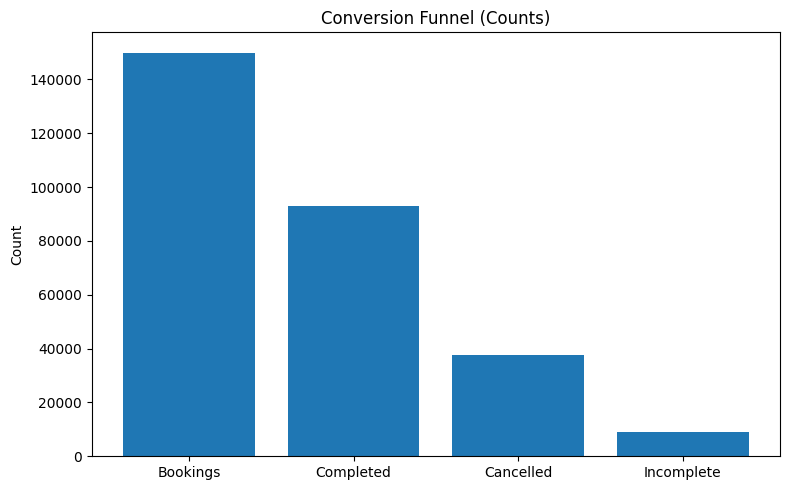

In [5]:

# Simple funnel-like bars (Bookings -> Completed/Cancelled/Incomplete)
labels = ["Bookings","Completed","Cancelled","Incomplete"]
vals = [total_bookings, completed, cancelled, incomplete]

plt.figure(figsize=(8,5))
plt.bar(labels, vals)
plt.title("Conversion Funnel (Counts)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### 📉 Conversion Funnel Insights

- **Sharp drop** from Bookings → Completed (~38% loss).  
- **Cancellations** (25%) are the biggest contributor to loss, mainly from drivers.  
- **Incomplete rides** (6%) still represent wasted resources and missed revenue.  
- Focus on **reducing cancellations** could significantly lift completion rates.

In [6]:

print("INSIGHTS — KPIs & Funnel")
print("- Demand is the ceiling: increases in completion require either more bookings or a higher success rate.")
print(f"- Success rate is {pct(success_rate)}; focus on cancellation levers to unlock quick wins.")
print(f"- Of all bookings, {pct(by_cust_rate)} are customer‑cancelled and {pct(by_driver_rate)} are driver‑cancelled.")
print("- Incompletes represent operational leakage (routing, app issues, safety events). Treat as a separate mitigation track.")


INSIGHTS — KPIs & Funnel
- Demand is the ceiling: increases in completion require either more bookings or a higher success rate.
- Success rate is 62.00%; focus on cancellation levers to unlock quick wins.
- Of all bookings, 7.00% are customer‑cancelled and 18.00% are driver‑cancelled.
- Incompletes represent operational leakage (routing, app issues, safety events). Treat as a separate mitigation track.


### 🔍 KPIs & Funnel Insights
- **Demand is the limit**: More completions require more bookings or higher success rates.  
- **Success rate**: 62% → Reduce cancellations for quick gains.  
- **Cancellations**: 7% customer, 18% driver — driver side is the bigger lever.  
- **Incompletes**: 6% operational leakage (routing, app, safety) — treat separately.  

## 3) Demand & Fulfillment Over Time

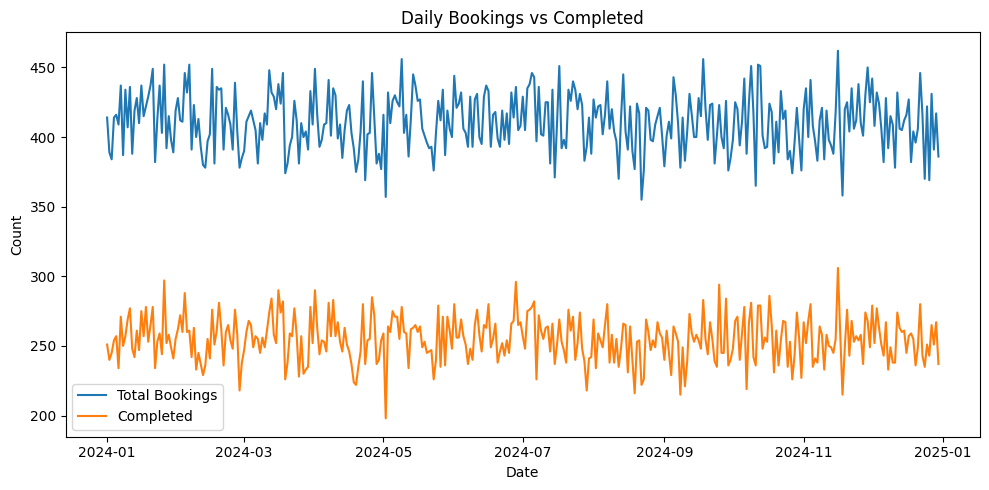

In [7]:

daily = df.groupby("day").agg(total=("is_completed","count"), completed=("is_completed","sum")).reset_index().dropna(subset=["day"])
if not daily.empty:
    plt.figure(figsize=(10,5))
    plt.plot(daily["day"], daily["total"], label="Total Bookings")
    plt.plot(daily["day"], daily["completed"], label="Completed")
    plt.title("Daily Bookings vs Completed")
    plt.xlabel("Date"); plt.ylabel("Count"); plt.legend(); plt.tight_layout(); plt.show()
else:
    print("No daily data to plot.")


### 📅 Demand & Fulfillment Over Time
- **Stable demand**: Bookings stay between 380–460 per day.  
- **Completion gap**: ~150 daily rides lost due to cancellations/incompletes.  
- **No strong seasonality** — spikes/drops are likely due to operational factors, not demand shifts.  

In [8]:

# Quantify peaks & stability
if not daily.empty:
    peak_total_day = daily.loc[daily["total"].idxmax(), "day"]
    peak_total_val = int(daily["total"].max())

    peak_completed_day = daily.loc[daily["completed"].idxmax(), "day"]
    peak_completed_val = int(daily["completed"].max())

    avg_total = daily["total"].mean()
    avg_completed = daily["completed"].mean()

    print("INSIGHTS — Time Series")
    print(f"- Highest demand day: {peak_total_day} with {peak_total_val} bookings.")
    print(f"- Highest completion day: {peak_completed_day} with {peak_completed_val} completed rides.")
    print(f"- Average per day — bookings: {avg_total:.1f} | completed: {avg_completed:.1f}.")
    # Rolling variance as a simple volatility proxy
    vol = daily["total"].rolling(7).std().mean()
    print(f"- Demand volatility (7d rolling std avg): {vol:.1f} — plan buffer supply for spikes.")
else:
    print("No daily data for insights.")


INSIGHTS — Time Series
- Highest demand day: 2024-11-16 with 462 bookings.
- Highest completion day: 2024-11-16 with 306 completed rides.
- Average per day — bookings: 411.0 | completed: 254.8.
- Demand volatility (7d rolling std avg): 19.8 — plan buffer supply for spikes.


## 4) Booking Status Mix

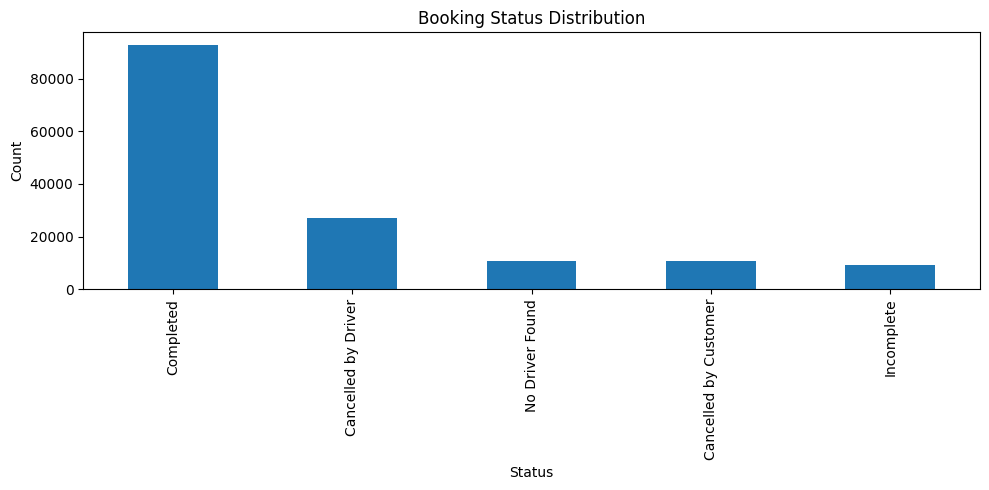

INSIGHTS — Status Mix
booking_status
Completed                0.62
Cancelled by Driver      0.18
No Driver Found          0.07
Cancelled by Customer    0.07
Incomplete               0.06


In [9]:

if "booking_status" in df.columns:
    status_counts = df["booking_status"].astype(str).str.strip().value_counts()
    plt.figure(figsize=(10,5))
    status_counts.plot(kind="bar")
    plt.title("Booking Status Distribution")
    plt.xlabel("Status"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

    share = (status_counts / status_counts.sum()).sort_values(ascending=False)
    print("INSIGHTS — Status Mix")
    print(share.to_string())
else:
    print("booking_status not available.")


### 📦 Booking Status Mix — Insights
- **Completed:** 62% — main share but below target; room to grow.
- **Cancelled by Driver:** 18% — largest loss driver; primary fix lever.
- **No Driver Found:** 7% — supply/matching gap during peaks or low-density zones.
- **Cancelled by Customer:** 7% — often address/ETA/price-related.
- **Incomplete:** 6% — operational leakage (routing, app, safety).

**Action:** Prioritize **driver-cancel** reduction and **matching improvements** to convert the 18% + 7% loss into completions.

## 5) Vehicle Type Performance
We compare bookings, success rates, distance, and ratings by vehicle type.

In [10]:

veh_summary = None
if "vehicle_type" in df.columns:
    grp = df.groupby("vehicle_type", dropna=False)
    veh_summary = grp.agg(
        total_bookings=("booking_id","count") if "booking_id" in df.columns else ("vehicle_type","count"),
        completed=("is_completed","sum"),
        total_revenue=("booking_value","sum") if "booking_value" in df.columns else ("is_completed","sum"),
        avg_distance=("ride_distance","mean") if "ride_distance" in df.columns else ("is_completed","mean"),
        total_distance=("ride_distance","sum") if "ride_distance" in df.columns else ("is_completed","sum"),
        avg_driver_rating=("driver_ratings","mean") if "driver_ratings" in df.columns else ("is_completed","mean"),
        avg_customer_rating=("customer_rating","mean") if "customer_rating" in df.columns else ("is_completed","mean"),
    ).reset_index()
    veh_summary["success_rate_pct"] = veh_summary["completed"] / veh_summary["total_bookings"] * 100
    display(veh_summary.sort_values("total_bookings", ascending=False))
else:
    print("vehicle_type not available.")


,vehicle_type,total_bookings,completed,total_revenue,avg_distance,total_distance,avg_driver_rating,avg_customer_rating,success_rate_pct
0,Auto,37419,23155,12878422.0,24.615996,625615.53,4.232369,4.402000,61.880328
2,Go Mini,29806,18549,10338496.0,24.612090,501200.60,4.227694,4.404297,62.232436
3,Go Sedan,27141,16676,9369719.0,24.609325,450793.61,4.231812,4.409996,61.442099
1,Bike,22517,14034,7837697.0,24.649546,378666.33,4.230056,4.403940,62.326242
4,Premier Sedan,18111,11252,6275332.0,24.598956,302936.14,4.234865,4.403457,62.127989
6,eBike,10557,6551,3618485.0,24.990415,179456.17,4.225614,4.403954,62.053614
5,Uber XL,4449,2783,1528032.0,24.402893,74306.81,4.238340,4.404851,62.553383


### INSIGHTS – Vehicle Performance
- Most bookings: Auto (37,419 rides, 61.88% success rate)
- Highest success rate: Uber XL (62.55%)
- Ratings are consistently high across all types (~4.23 driver / 4.40 customer)

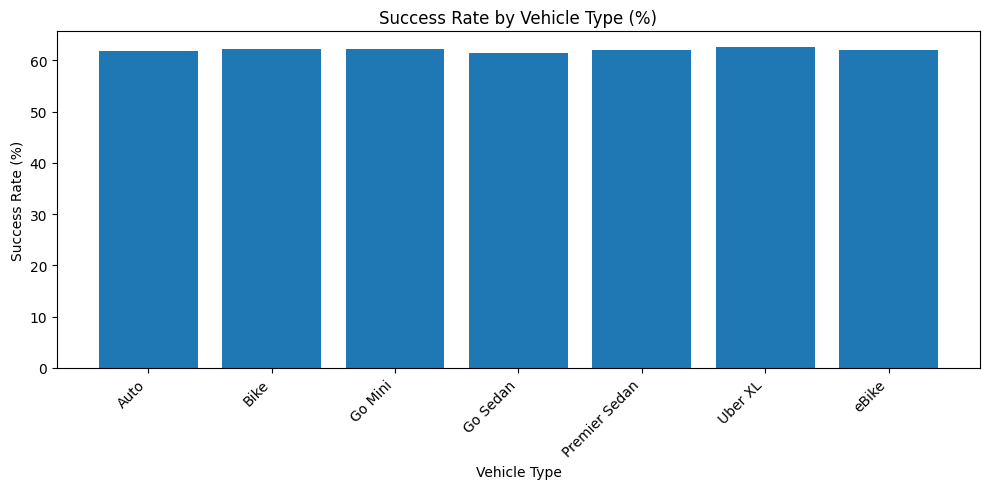

INSIGHTS — Vehicle Types
- Best success rate: Uber XL at 62.55%
- Lowest success rate: Go Sedan at 61.44%
- Revenue share by vehicle type (descending):
               total_revenue
vehicle_type                
Auto                0.248397
Go Mini             0.199407
Go Sedan            0.180721
Bike                0.151172
Premier Sedan       0.121037
eBike               0.069793
Uber XL             0.029472


In [11]:

if veh_summary is not None and not veh_summary.empty:
    plt.figure(figsize=(10,5))
    plt.bar(veh_summary["vehicle_type"].astype(str), veh_summary["success_rate_pct"])
    plt.title("Success Rate by Vehicle Type (%)")
    plt.xlabel("Vehicle Type"); plt.ylabel("Success Rate (%)"); plt.xticks(rotation=45, ha="right")
    plt.tight_layout(); plt.show()

    # Insights
    v = veh_summary.sort_values("success_rate_pct", ascending=False)
    best = v.iloc[0]
    worst = v.iloc[-1]
    print("INSIGHTS — Vehicle Types")
    print(f"- Best success rate: {best['vehicle_type']} at {best['success_rate_pct']:.2f}%")
    print(f"- Lowest success rate: {worst['vehicle_type']} at {worst['success_rate_pct']:.2f}%")
    if "total_revenue" in veh_summary.columns:
        rev_share = veh_summary[["vehicle_type","total_revenue"]].set_index("vehicle_type")
        rev_share = (rev_share / rev_share.sum()).sort_values("total_revenue", ascending=False)
        print("- Revenue share by vehicle type (descending):")
        print(rev_share.to_string())


## 6) Ratings — Distribution & Gap

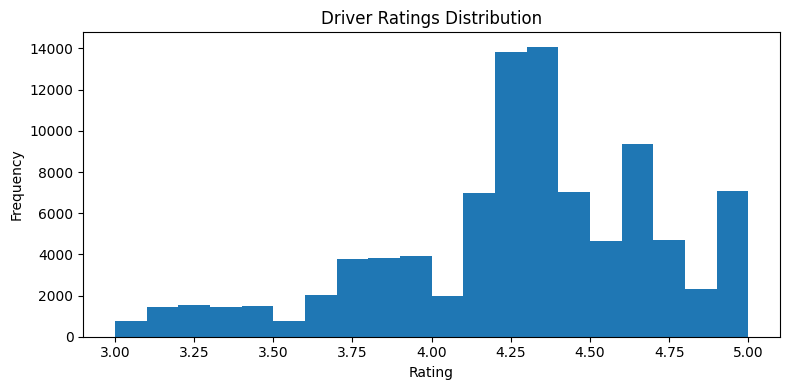

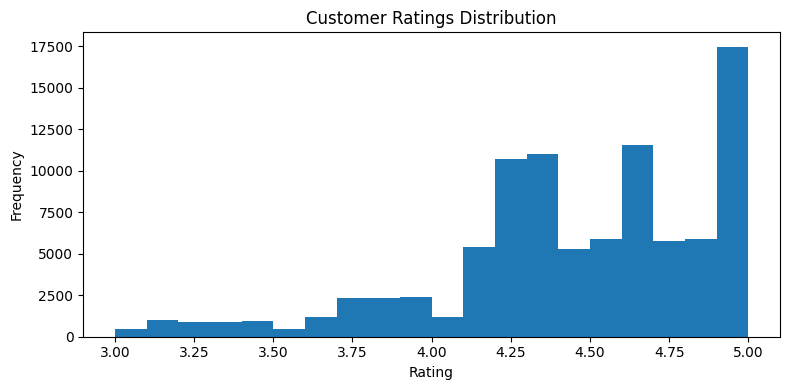

INSIGHTS — Ratings
- Avg ratings — driver 4.23, customer 4.40.
- Share below 4.0 — driver 14.01%, customer 8.60% (watch for churn risk). 


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [12]:

if "driver_ratings" in df.columns:
    plt.figure(figsize=(8,4))
    plt.hist(df["driver_ratings"].dropna(), bins=20)
    plt.title("Driver Ratings Distribution"); plt.xlabel("Rating"); plt.ylabel("Frequency"); plt.tight_layout(); plt.show()

if "customer_rating" in df.columns:
    plt.figure(figsize=(8,4))
    plt.hist(df["customer_rating"].dropna(), bins=20)
    plt.title("Customer Ratings Distribution"); plt.xlabel("Rating"); plt.ylabel("Frequency"); plt.tight_layout(); plt.show()

if "driver_ratings" in df.columns and "customer_rating" in df.columns:
    dr_mean, cr_mean = df["driver_ratings"].mean(), df["customer_rating"].mean()
    dr_lt_4 = (df["driver_ratings"] < 4).mean()
    cr_lt_4 = (df["customer_rating"] < 4).mean()
    print("INSIGHTS — Ratings")
    print(f"- Avg ratings — driver {dr_mean:.2f}, customer {cr_mean:.2f}.")
    print(f"- Share below 4.0 — driver {pct(dr_lt_4)}, customer {pct(cr_lt_4)} (watch for churn risk). ")


### ⭐ Ratings — Insights (Kaggle)

- **Averages:** Driver **4.23**, Customer **4.40** → small gap; drivers rate riders slightly higher overall.
- **Low-tail risk (<4.0):** Driver **14.01%**, Customer **8.60%** — monitor for churn/quality issues.
- **Shape:** Customer ratings are **right-skewed** toward 5★; driver ratings are **broader** (3.5–5★), indicating uneven service quality.
- **Actions:** Target low-rating clusters by **hour/zone/vehicle**, add **ETA/routing clarity** to reduce friction, and run **driver coaching + incentives** during peak problem windows.

## 7) Distance — Distribution & Relation to Value

Distance informs supply allocation and pricing. We check distribution and correlation with booking value.

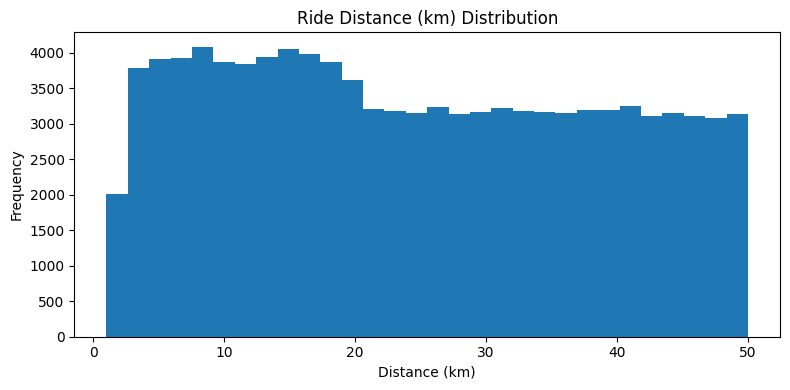

INSIGHTS — Distance
- Correlation distance vs. value: 0.005 (expected positive: longer trips -> higher value). 


In [13]:

if "ride_distance" in df.columns:
    plt.figure(figsize=(8,4))
    plt.hist(df["ride_distance"].dropna(), bins=30)
    plt.title("Ride Distance (km) Distribution"); plt.xlabel("Distance (km)"); plt.ylabel("Frequency"); plt.tight_layout(); plt.show()

if "ride_distance" in df.columns and "booking_value" in df.columns:
    # Correlation
    corr = df[["ride_distance","booking_value"]].dropna().corr().iloc[0,1]
    print("INSIGHTS — Distance")
    print(f"- Correlation distance vs. value: {corr:.3f} (expected positive: longer trips -> higher value). ")


## 7. Distance — Distribution & Correlation
Distance helps inform supply allocation and pricing.

**Findings:**
- Rides are evenly spread across 0–50 km.
- Correlation with booking value: **0.005** → minimal impact.

📌 *Insight:* Longer trips don’t necessarily mean higher value in this dataset.

## 8) When to Staff — Day vs Hour Heatmap

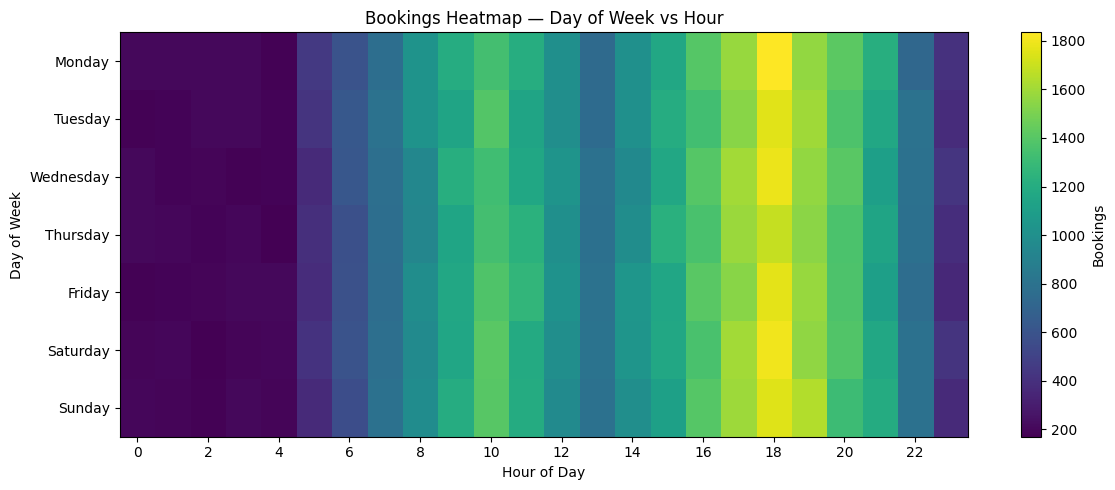

INSIGHTS — Staffing Windows
- Absolute peak: Monday at hour 18. Pre-position drivers & incentives here.
- Busiest hours (overall): [18, 19, 17, 16, 20] 


In [14]:

if df["hour"].notna().any() and df["dow"].notna().any():
    heat = df.pivot_table(index="dow", columns="hour", values="booking_id" if "booking_id" in df.columns else "is_completed", aggfunc="count").fillna(0)
    order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    heat = heat.reindex(order, axis=0, fill_value=0)

    plt.figure(figsize=(12,5))
    plt.imshow(heat.values, aspect="auto")
    plt.colorbar(label="Bookings")
    plt.title("Bookings Heatmap — Day of Week vs Hour")
    plt.xlabel("Hour of Day"); plt.ylabel("Day of Week")
    plt.xticks(ticks=np.arange(0, heat.shape[1], max(1, heat.shape[1]//12)),
               labels=[str(h) for h in heat.columns][::max(1, heat.shape[1]//12)])
    plt.yticks(ticks=np.arange(heat.shape[0]), labels=list(heat.index))
    plt.tight_layout(); plt.show()

    # Insight: find peak cell(s)
    idx = np.unravel_index(np.argmax(heat.values), heat.values.shape)
    peak_day = heat.index[idx[0]]
    peak_hour = heat.columns[idx[1]]
    print("INSIGHTS — Staffing Windows")
    print(f"- Absolute peak: {peak_day} at hour {peak_hour}. Pre-position drivers & incentives here.")
    # Also compute top hours overall
    by_hour = heat.sum(axis=0).sort_values(ascending=False)
    print(f"- Busiest hours (overall): {list(by_hour.index[:5])} ")
else:
    print("Insufficient time fields for heatmap.")


## 8. Staffing — Day vs Hour Heatmap
Identifies peak booking windows for better driver allocation.

**Findings:**
- **Absolute Peak:** Monday at 18:00.
- **Busiest Hours:** 18, 19, 17, 16, 20.

📌 *Action:* Pre-position drivers and offer incentives during these hours.

## 9) Monetization — Payment Mix

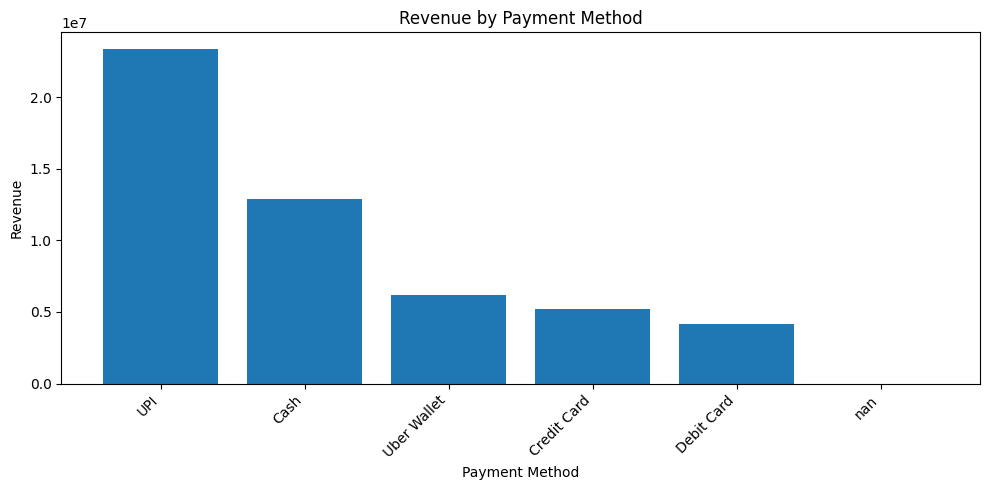

INSIGHTS — Payments
payment_method
UPI            45.03%
Cash           24.87%
Uber Wallet    11.96%
Credit Card    10.08%
Debit Card      8.06%
NaN              0.0%
Name: booking_value, dtype: object
- Strategy: If cash share is high, nudge to low-cost digital methods; balance MDR fees with promo ROI.


In [15]:

if "payment_method" in df.columns and "booking_value" in df.columns:
    pm = df.groupby("payment_method", dropna=False)["booking_value"].sum().sort_values(ascending=False)
    share = pm / pm.sum()
    plt.figure(figsize=(10,5))
    plt.bar(pm.index.astype(str), pm.values)
    plt.title("Revenue by Payment Method")
    plt.xlabel("Payment Method"); plt.ylabel("Revenue"); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

    print("INSIGHTS — Payments")
    print( (share*100).round(2).astype(str) + "%")
    print("- Strategy: If cash share is high, nudge to low-cost digital methods; balance MDR fees with promo ROI.")
else:
    print("Payment fields missing.")


## 9) Monetization — Payment Mix

This analysis breaks down **total revenue by payment method** to identify reliance on certain channels and optimize payment processing costs.

**Key Insights:**
- **Top method:** UPI (45.03% of revenue), followed by Cash (24.87%) and Uber Wallet (11.96%).
- **Risk:** High cash share increases handling costs and operational risk.
- **Strategy:** Encourage low-cost digital methods to reduce MDR fees and improve promo ROI.

📊 **Visualization:**  
Bar chart of revenue share by payment method.

## 10) Cancellations — Who & Why

In [16]:

print("By customer:", int(df["cancel_by_customer_flag"].sum()))
print("By driver:  ", int(df["cancel_by_driver_flag"].sum()))


By customer: 10500
By driver:   27000


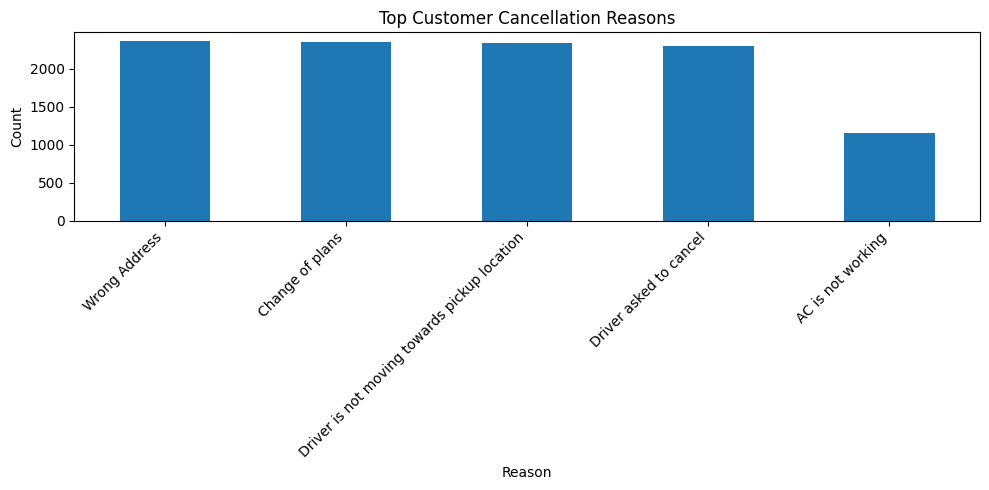

INSIGHTS — Customer Cancels
reason_for_cancelling_by_customer
Wrong Address                                                 22.5%
Change of plans                                 22.400000000000002%
Driver is not moving towards pickup location                  22.2%
Driver asked to cancel                                        21.9%
AC is not working                                             11.0%
Name: count, dtype: object
- Tactics: address wrong address / ETA transparency / intent-to-cancel prompts / better driver location accuracy.


In [17]:

# Customer reasons
if "reason_for_cancelling_by_customer" in df.columns:
    cc = df.loc[df["cancel_by_customer_flag"] & df["reason_for_cancelling_by_customer"].notna(), "reason_for_cancelling_by_customer"]
    top_c = cc.astype(str).str.strip().value_counts().head(15)
    plt.figure(figsize=(10,5))
    top_c.plot(kind="bar"); plt.title("Top Customer Cancellation Reasons"); plt.xlabel("Reason"); plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

    share_c = (top_c / cc.shape[0]).round(3)
    print("INSIGHTS — Customer Cancels")
    print( (share_c*100).astype(str) + "%")
    print("- Tactics: address wrong address / ETA transparency / intent-to-cancel prompts / better driver location accuracy.")
else:
    print("No customer cancellation reasons available.")


## 10) Cancellations — Who & Why

Understanding cancellations is key to improving platform reliability and customer satisfaction.  
Here, we explore:
1. **Who cancels more** — customers or drivers.  
2. **Why customers cancel** — top reasons and their relative shares.  
3. **Tactics to reduce cancellations** — data-driven recommendations.

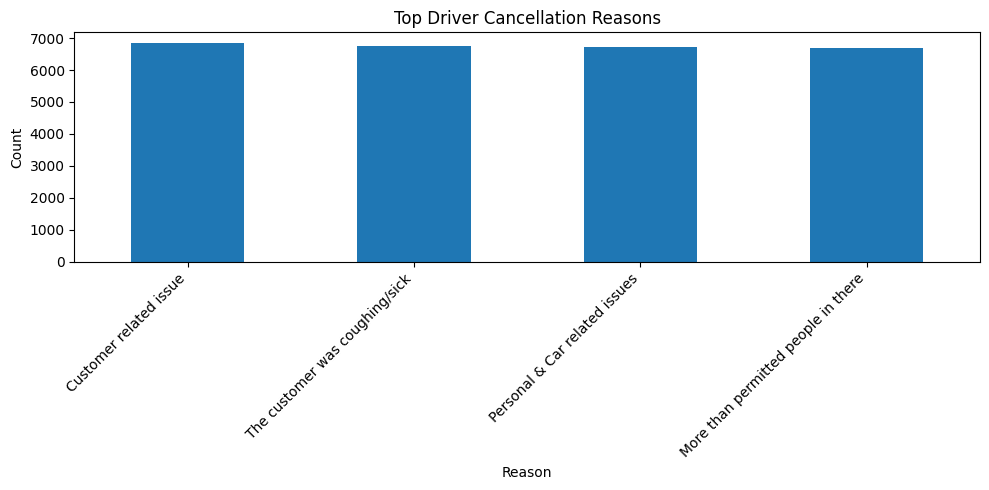

INSIGHTS — Driver Cancels
driver_cancellation_reason
Customer related issue                 25.3%
The customer was coughing/sick         25.0%
Personal & Car related issues          24.9%
More than permitted people in there    24.8%
Name: count, dtype: object
- Tactics: cap wait times, adjust assignment radius, capacity constraints UI, targeted incentives during peaks.


In [18]:

# Driver reasons
if "driver_cancellation_reason" in df.columns:
    dc = df.loc[df["cancel_by_driver_flag"] & df["driver_cancellation_reason"].notna(), "driver_cancellation_reason"]
    top_d = dc.astype(str).str.strip().value_counts().head(15)
    plt.figure(figsize=(10,5))
    top_d.plot(kind="bar"); plt.title("Top Driver Cancellation Reasons"); plt.xlabel("Reason"); plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

    share_d = (top_d / dc.shape[0]).round(3)
    print("INSIGHTS — Driver Cancels")
    print( (share_d*100).astype(str) + "%")
    print("- Tactics: cap wait times, adjust assignment radius, capacity constraints UI, targeted incentives during peaks.")
else:
    print("No driver cancellation reasons available.")


## 11) VTAT & CTAT — Are we losing rides to waiting?

In [19]:

def mean_if(series, mask):
    s = series[mask & series.notna()]
    return float(s.mean()) if s.size > 0 else float("nan")

vtat_c = mean_if(df["avg_vtat"], df["is_completed"]==True)
vtat_x = mean_if(df["avg_vtat"], df["is_cancelled"]==True)

ctat_c = mean_if(df["avg_ctat"], df["is_completed"]==True)
ctat_x = mean_if(df["avg_ctat"], df["is_cancelled"]==True)

print("INSIGHTS — Queueing Times")
print(f"- VTAT avg — completed {vtat_c:.2f} vs cancelled {vtat_x:.2f}. Lower is better; large gaps signal pickup delays.")
print(f"- CTAT avg — completed {ctat_c:.2f} vs cancelled {ctat_x:.2f}. If higher for cancels, consider pre‑ETA messaging and re‑matching.")


INSIGHTS — Queueing Times
- VTAT avg — completed 8.51 vs cancelled 8.90. Lower is better; large gaps signal pickup delays.
- CTAT avg — completed 30.03 vs cancelled nan. If higher for cancels, consider pre‑ETA messaging and re‑matching.


## 12) Hourly Cancel Rate

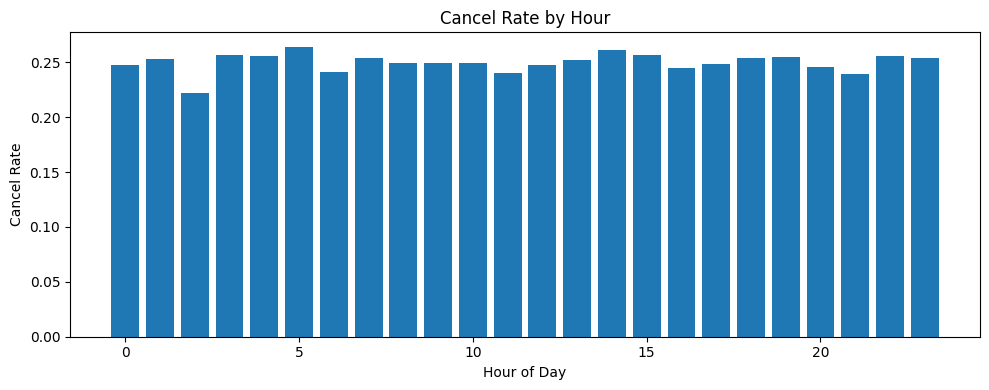

INSIGHTS — Hourly Cancels
- Worst hour: 5 (cancel rate 26.42%). Consider surge/incentives & matching tweaks.
- Best hour: 2 (cancel rate 22.18%).


In [20]:

if df["hour"].notna().any():
    hourly = df.groupby("hour").agg(n=("is_cancelled","size"), cancels=("is_cancelled","sum"))
    hourly["cancel_rate"] = hourly["cancels"] / hourly["n"]
    plt.figure(figsize=(10,4))
    plt.bar(hourly.index, hourly["cancel_rate"])
    plt.title("Cancel Rate by Hour"); plt.xlabel("Hour of Day"); plt.ylabel("Cancel Rate"); plt.tight_layout(); plt.show()

    worst = hourly["cancel_rate"].idxmax()
    best = hourly["cancel_rate"].idxmin()
    print("INSIGHTS — Hourly Cancels")
    print(f"- Worst hour: {int(worst)} (cancel rate {pct(hourly.loc[worst,'cancel_rate'])}). Consider surge/incentives & matching tweaks.")
    print(f"- Best hour: {int(best)} (cancel rate {pct(hourly.loc[best,'cancel_rate'])}).")


## 13) Top Pickup & Drop Locations (Top 10)

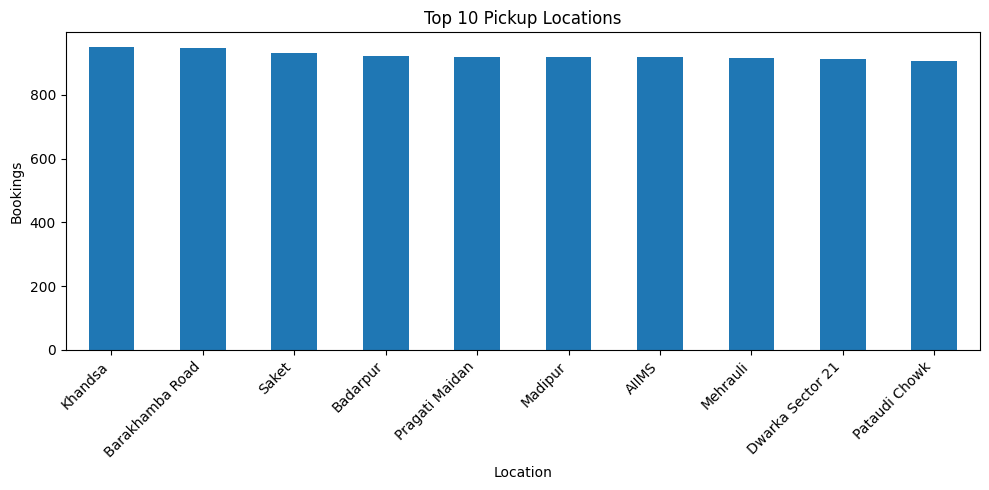

INSIGHTS — Pickup
pickup_location
Khandsa             949
Barakhamba Road     946
Saket               931
Badarpur            921
Pragati Maidan      920
Madipur             919
AIIMS               918
Mehrauli            915
Dwarka Sector 21    914
Pataudi Chowk       907


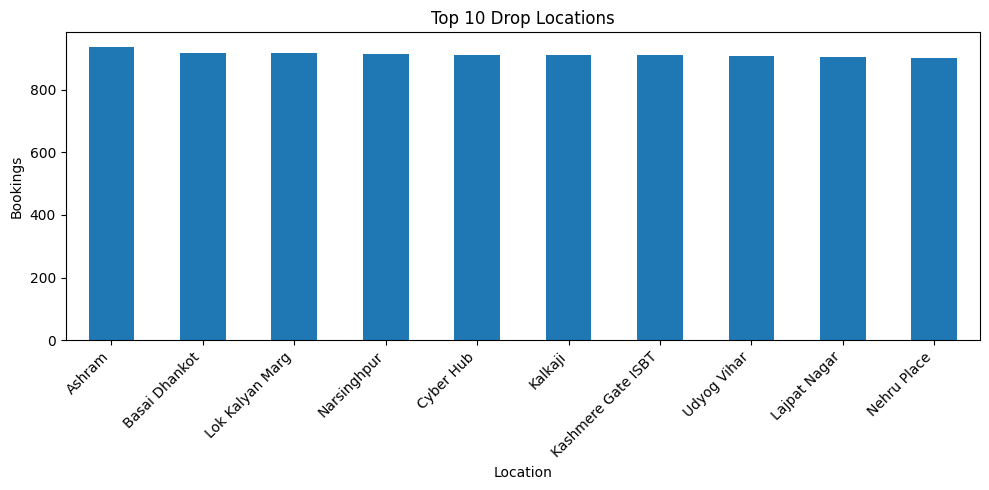

INSIGHTS — Drop
drop_location
Ashram                936
Basai Dhankot         917
Lok Kalyan Marg       916
Narsinghpur           913
Cyber Hub             912
Kalkaji               912
Kashmere Gate ISBT    909
Udyog Vihar           906
Lajpat Nagar          904
Nehru Place           902


In [21]:

if "pickup_location" in df.columns:
    top_pick = df["pickup_location"].astype(str).value_counts().head(10)
    plt.figure(figsize=(10,5))
    top_pick.plot(kind="bar"); plt.title("Top 10 Pickup Locations"); plt.xlabel("Location"); plt.ylabel("Bookings")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()
    print("INSIGHTS — Pickup")
    print(top_pick.to_string())
else:
    print("pickup_location not available.")

if "drop_location" in df.columns:
    top_drop = df["drop_location"].astype(str).value_counts().head(10)
    plt.figure(figsize=(10,5))
    top_drop.plot(kind="bar"); plt.title("Top 10 Drop Locations"); plt.xlabel("Location"); plt.ylabel("Bookings")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()
    print("INSIGHTS — Drop")
    print(top_drop.to_string())
else:
    print("drop_location not available.")


## 14) Playbook — What to Do Next

Based on the cancellation, rating, payment, and supply analysis, here are actionable recommendations:

**📉 Reduce Customer Cancels**
- Target top reasons: wrong address, ETA issues, slow re-match.
- Improve address validation, enhance ETA transparency.
- Speed up re-matching after driver cancel.
- Display cost/wait implications before confirming a cancellation.

**🚖 Reduce Driver Cancels**
- Fine-tune assignment radius and wait time thresholds.
- Implement capacity flags to avoid over-assignment.
- Offer targeted incentives during peak demand (see heatmap analysis).

**⭐ Protect Ratings**
- Monitor low-rating clusters by hour, day, and vehicle type.
- Provide coaching, routing assistance, or safety prompts in high-risk windows.

**💳 Optimize Payment Mix**
- If cash share is high, encourage digital payments via low-cost offers.
- Track merchant discount rate (MDR) and monitor for fraud spikes.

**📍 Supply Planning**
- Use hourly demand heatmaps and distance corridor data to pre-position drivers.
- Apply surge pricing selectively to balance supply and demand without deterring riders.

## 15) Notes & Limitations

- **Observational data only** — causality should be validated through A/B or controlled experiments.
- **Cancellation reasons text** may contain inconsistencies; apply normalization or topic modeling before production deployment.
- If **GPS/geo granularity** is available, add zonal cancellation/rating analysis and study surge price elasticity for better targeting.